In [1]:
pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in c:\programdata\anaconda3\lib\site-packages (0.1.63)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import warnings

In [3]:
plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Download General Electric data and calculate the returns
df = yf.download("GE", start = "1985-01-01", end = "2020-12-31", progress = False)

# Select the name of the header "Adj Close"
df = df[["Adj Close"]].rename(columns={"Adj Close": "adj_close"})

# Calculate log returns
df["log_rtn"] = np.log(df.adj_close / df.adj_close.shift(1))

# Remove NaN values
df = df[['adj_close', 'log_rtn']].dropna(how = 'any')

df

,adj_close,log_rtn
Date,,
1985-01-02,6.669522,-0.011099
1985-01-03,6.699296,0.004454
1985-01-04,6.669522,-0.004454
1985-01-07,6.743961,0.011099
1985-01-08,6.758844,0.002205
...,...,...
2020-12-23,86.749962,0.023289
2020-12-24,85.072472,-0.019526
2020-12-28,84.992599,-0.000939


In [5]:
# Calculate the normal Probability Density Function
r_range = np.linspace (min (df.log_rtn), max (df.log_rtn), num = 1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()

norm_pdf = scs.norm.pdf (r_range, loc = mu, scale = sigma)


Text(0.5, 1.0, 'Q-Q plot')

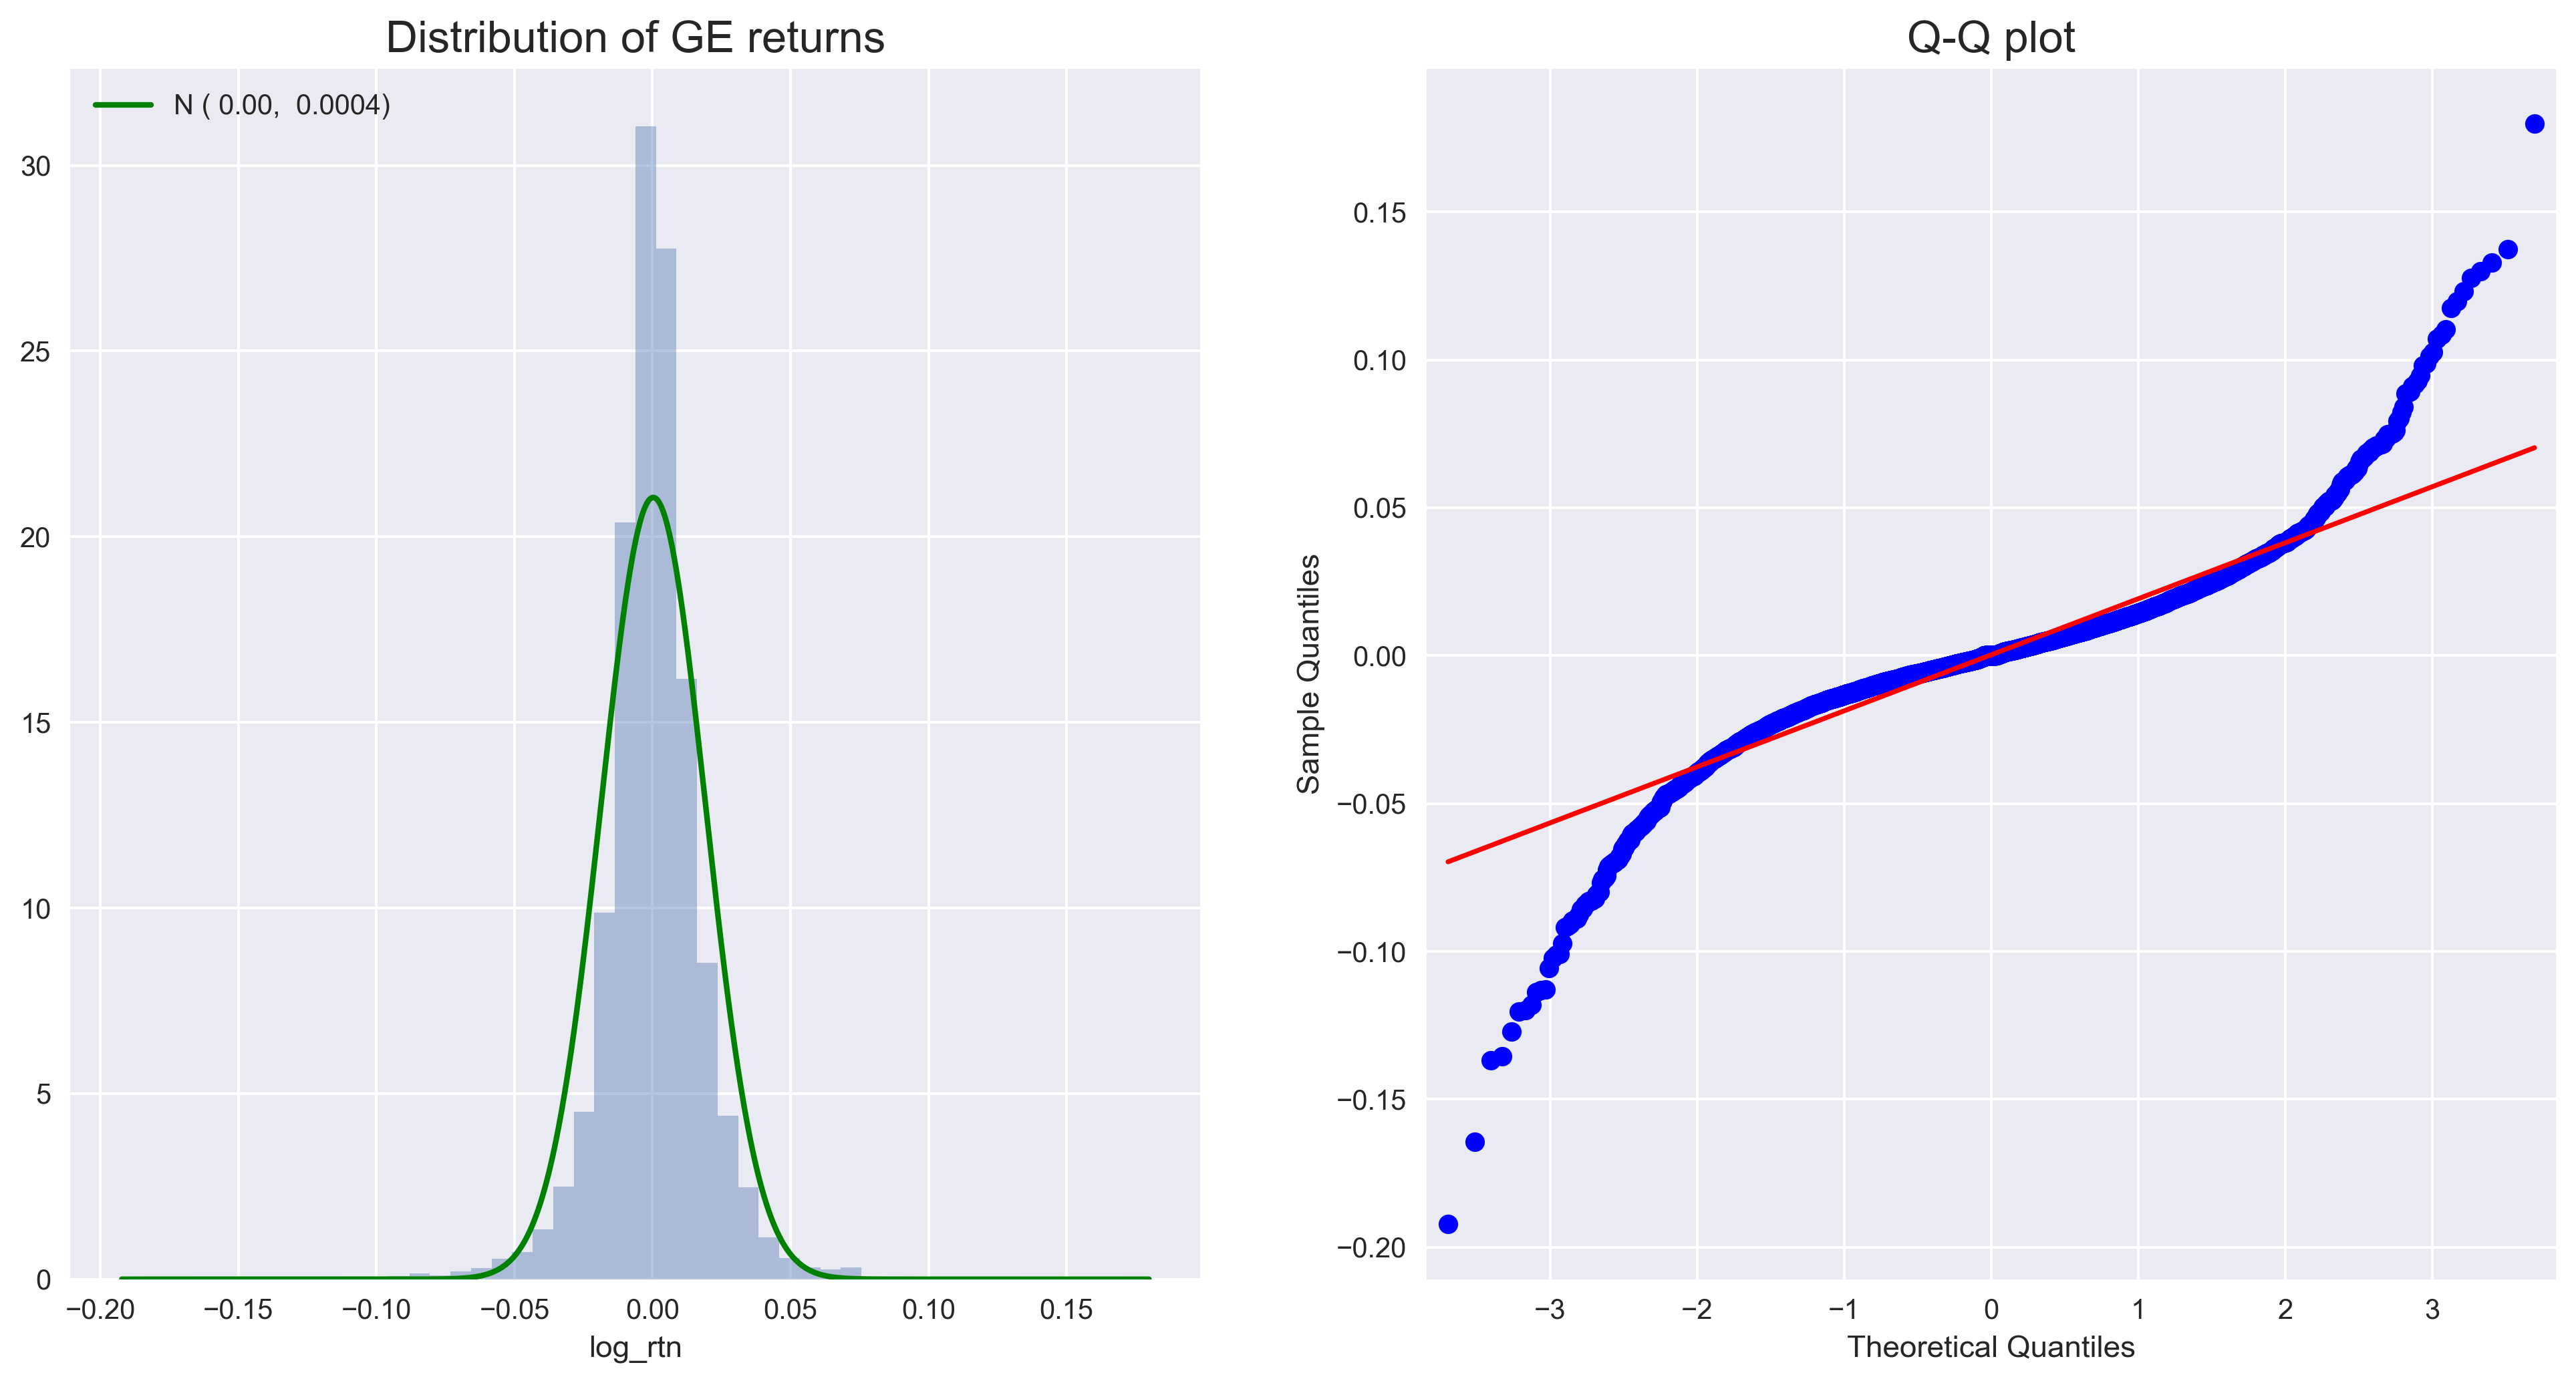

In [6]:
# Plot the histogram and the Q-Q plot 
fig, ax = plt.subplots (1,2, figsize = (16, 8))

# Histogram
sns.distplot (df.log_rtn, kde = False, norm_hist = True, ax = ax [0])
ax[0].set_title ("Distribution of GE returns", fontsize = 16)
ax[0].plot (r_range, norm_pdf, "g", lw = 2, label = f"N ({mu: .2f}, {sigma**2: .4f})")
ax[0].legend (loc = "upper left");

# Q-Q plot
qq = sm.qqplot (df.log_rtn.values, line = "s", ax = ax[1])
ax[1].set_title ("Q-Q plot", fontsize = 16)

In [7]:
#Print the summary statistics of the log returns:

jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df.log_rtn.mean():.4f}')
print(f'Median: {df.log_rtn.median():.4f}')
print(f'Min: {df.log_rtn.min():.4f}')
print(f'Max: {df.log_rtn.max():.4f}')
print(f'Standard Deviation: {df.log_rtn.std():.4f}')
print(f'Skewness: {df.log_rtn.skew():.4f}')
print(f'Kurtosis: {df.log_rtn.kurtosis():.4f}') 
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

---------- Descriptive Statistics ----------
Range of dates: 1985-01-02 - 2020-12-30
Number of observations: 9074
Mean: 0.0003
Median: 0.0000
Min: -0.1922
Max: 0.1798
Standard Deviation: 0.0189
Skewness: -0.1306
Kurtosis: 9.1039
Jarque-Bera statistic: 31322.57 with p-value: 0.00


Volatility Clustering

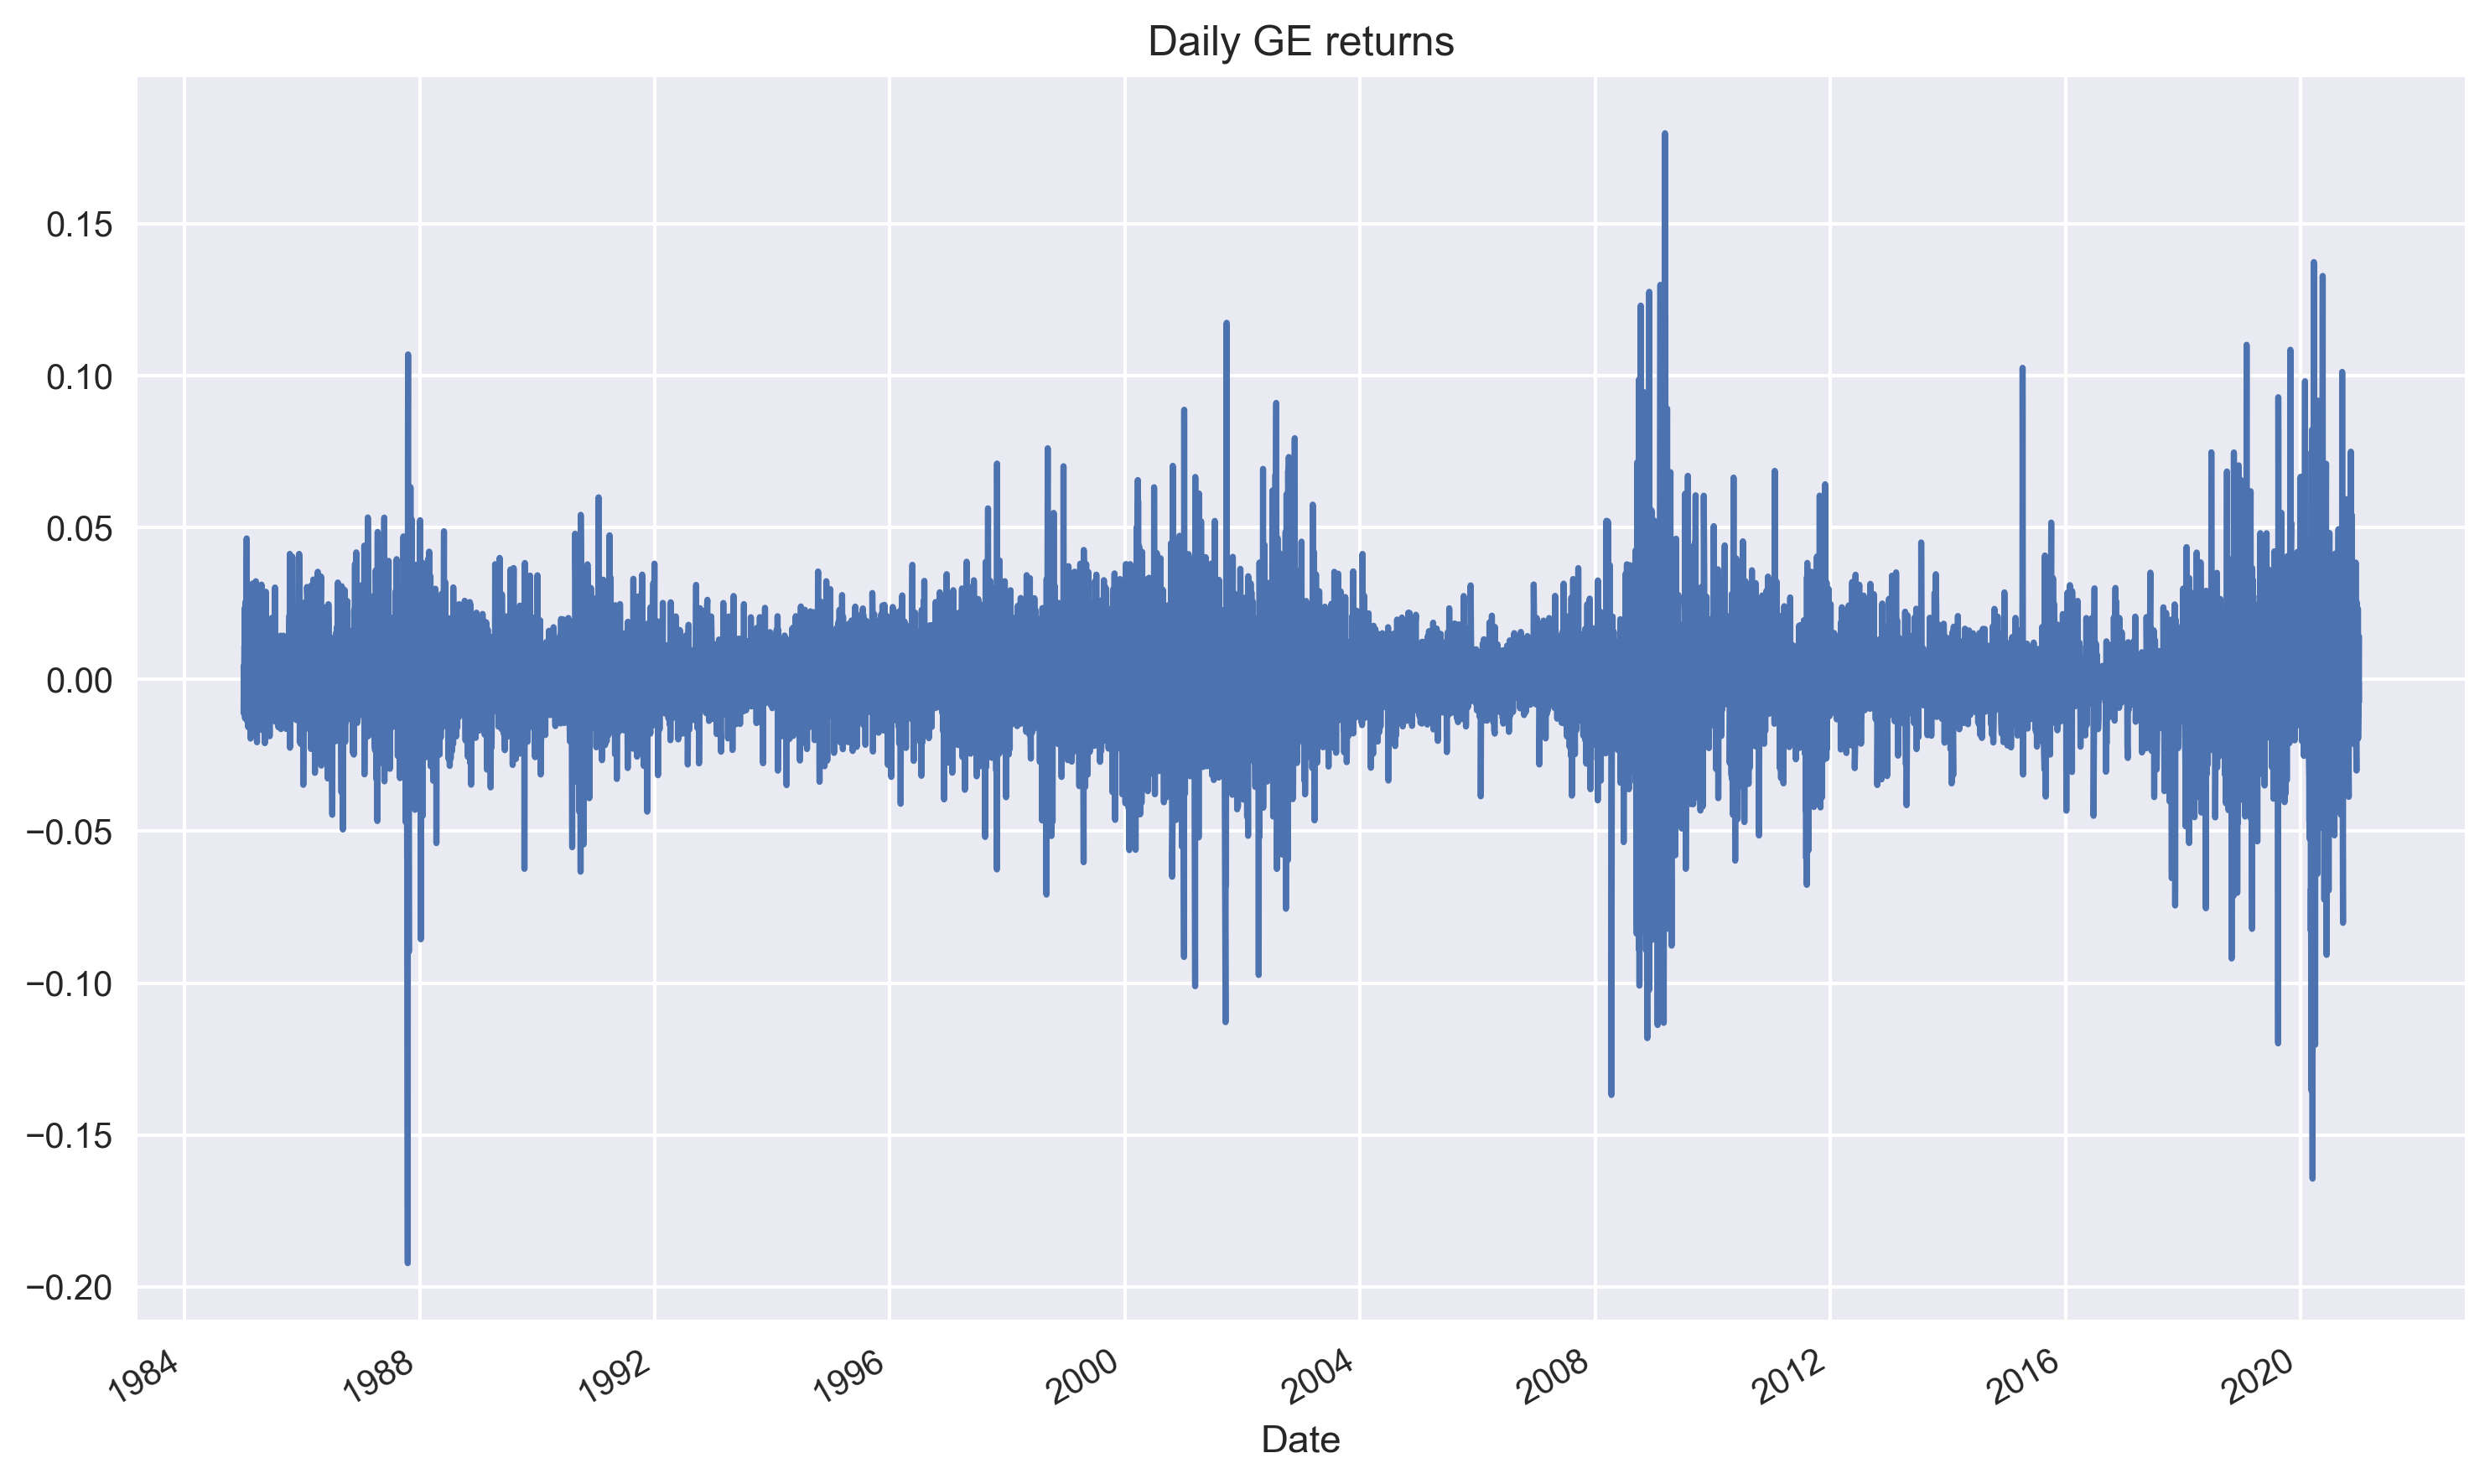

In [8]:
# Visualise the log returns series
# We can observe clear clusters of volatility - periods of higher positive and negative returns. 
df.log_rtn.plot(title = "Daily GE returns", figsize=(10, 6))

plt.tight_layout()
plt.show()

Absence of autocorrelation in returns

In [9]:
# Define the parameters for creating the autocorrelation plots 

N_lags = 50
significance_level = 0.05

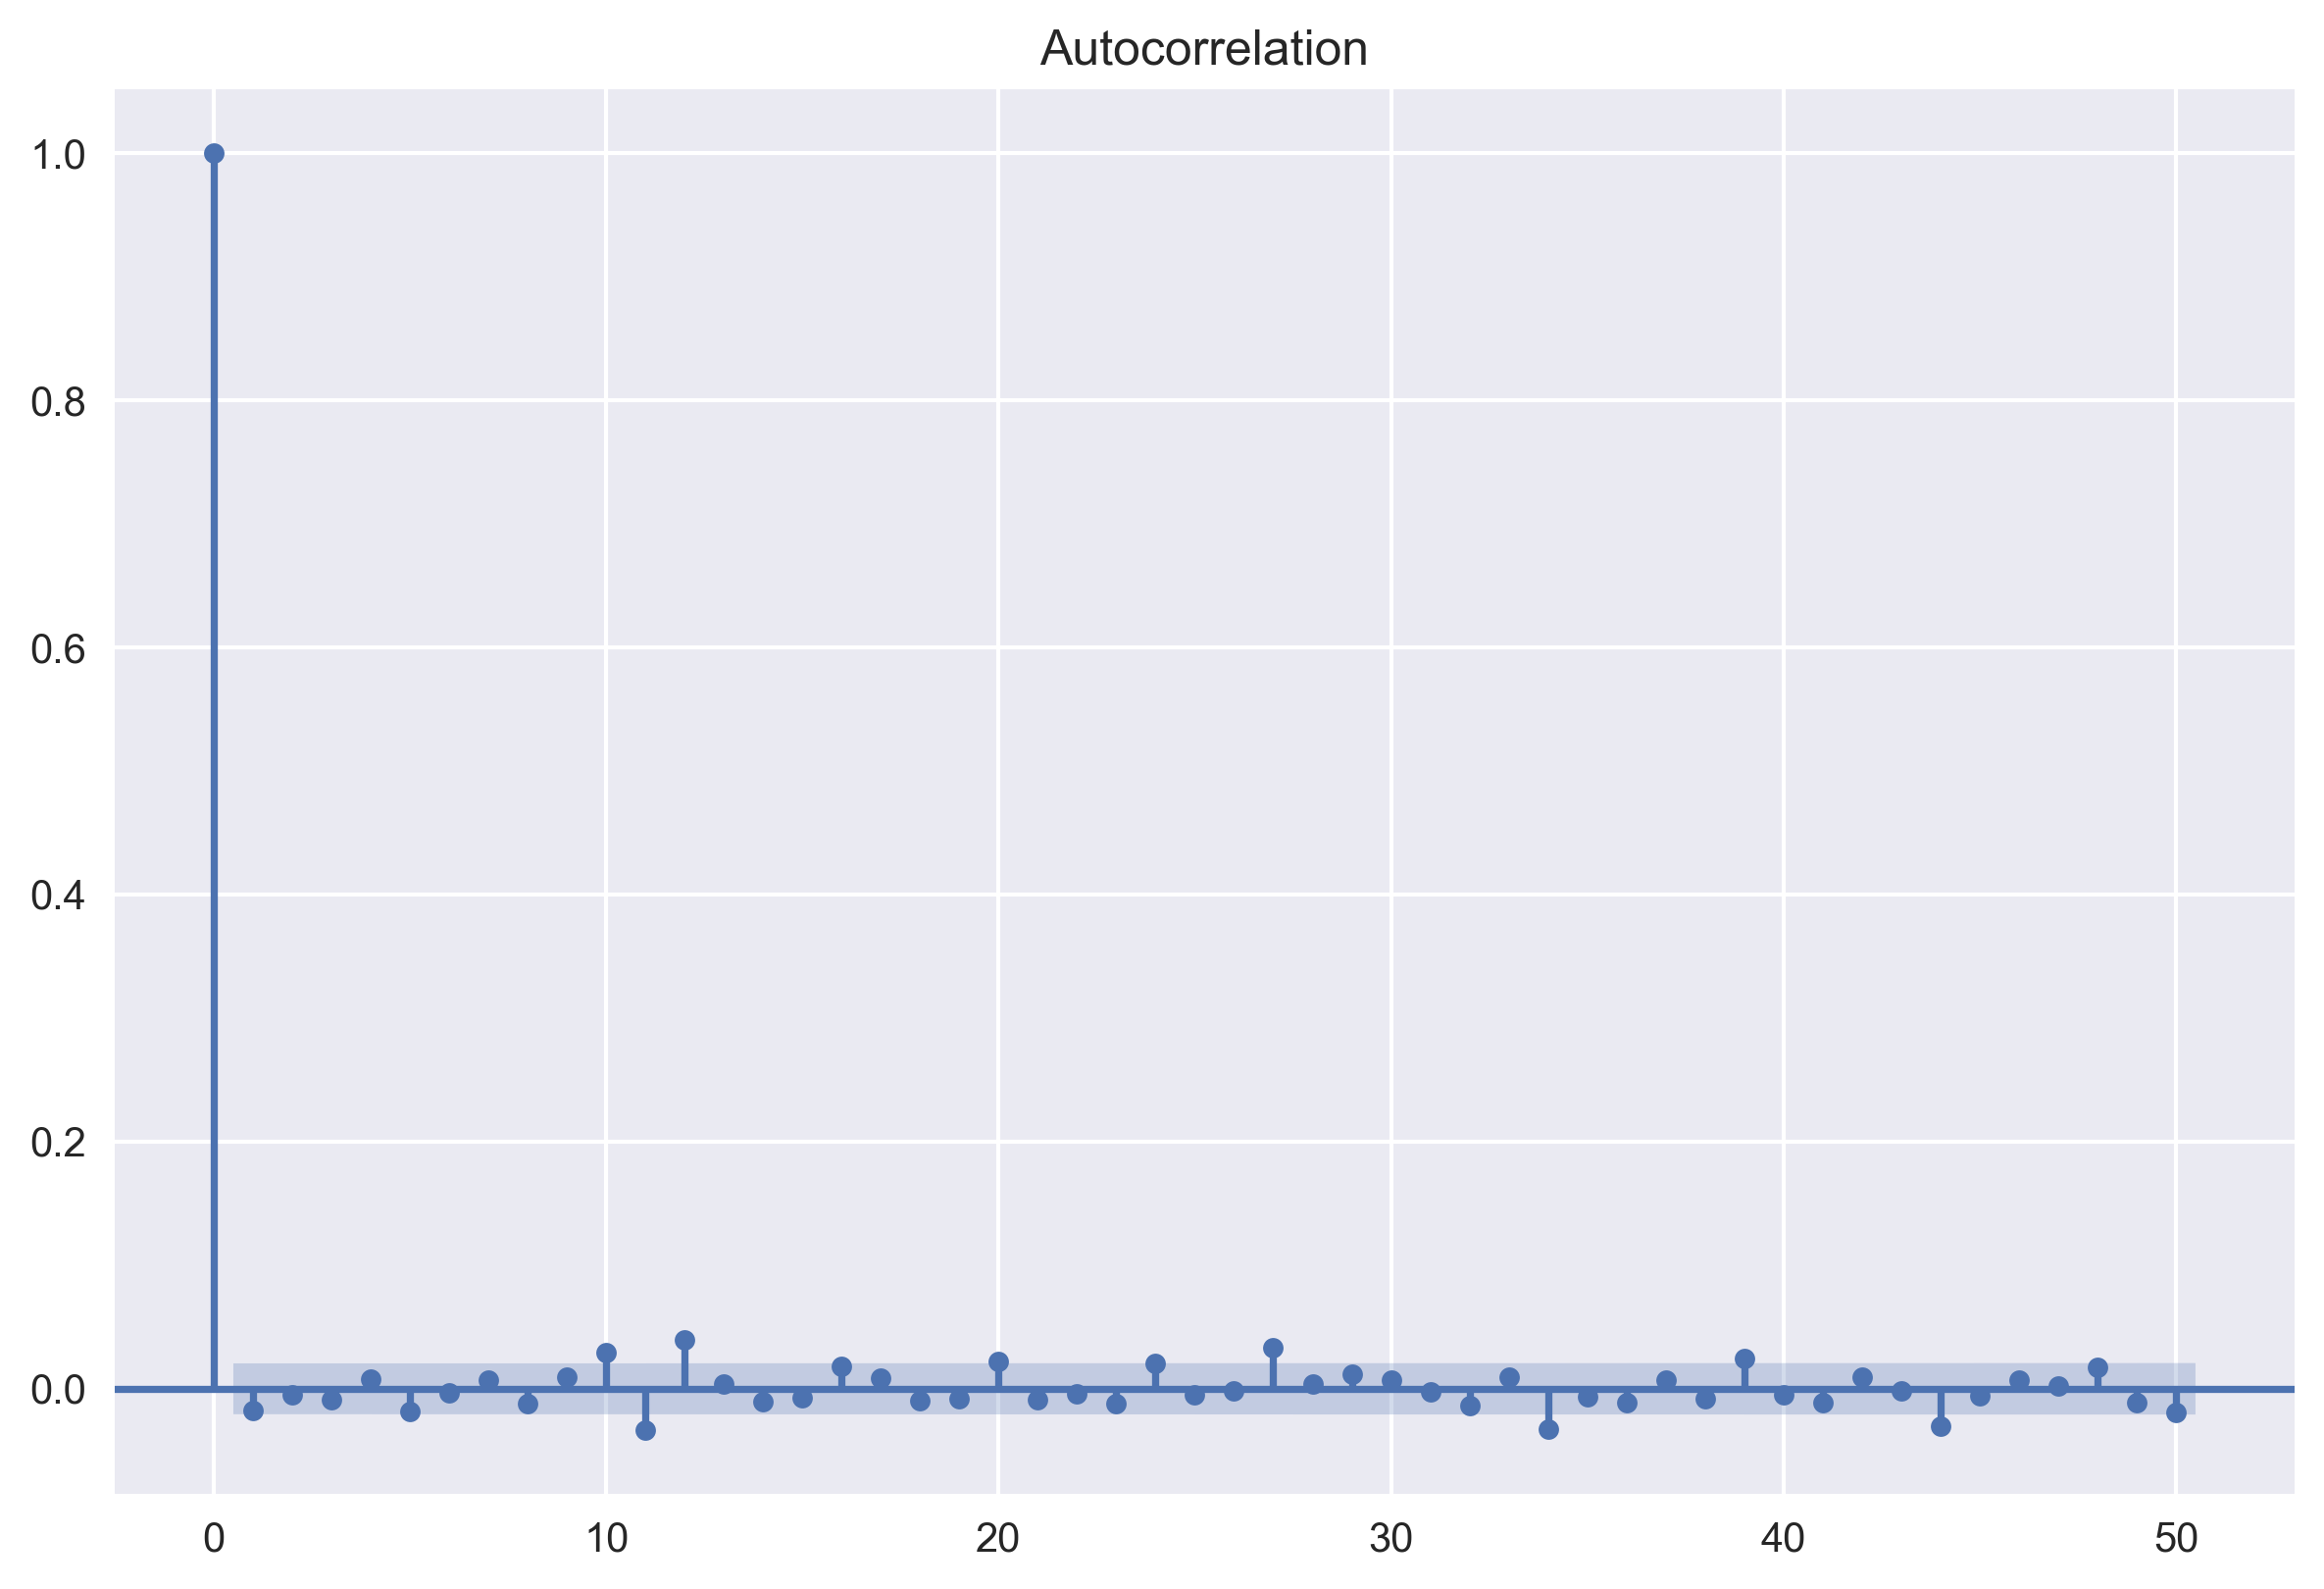

In [11]:
# Run the following code to create the autocorrelation function (ACF) to plot of log returns
acf = smt.graphics.plot_acf (df.log_rtn, lags = N_lags, alpha = significance_level)

plt.tight_layout()
plt.show()

Small and decreaing autocorrelation in squared/absolute returns

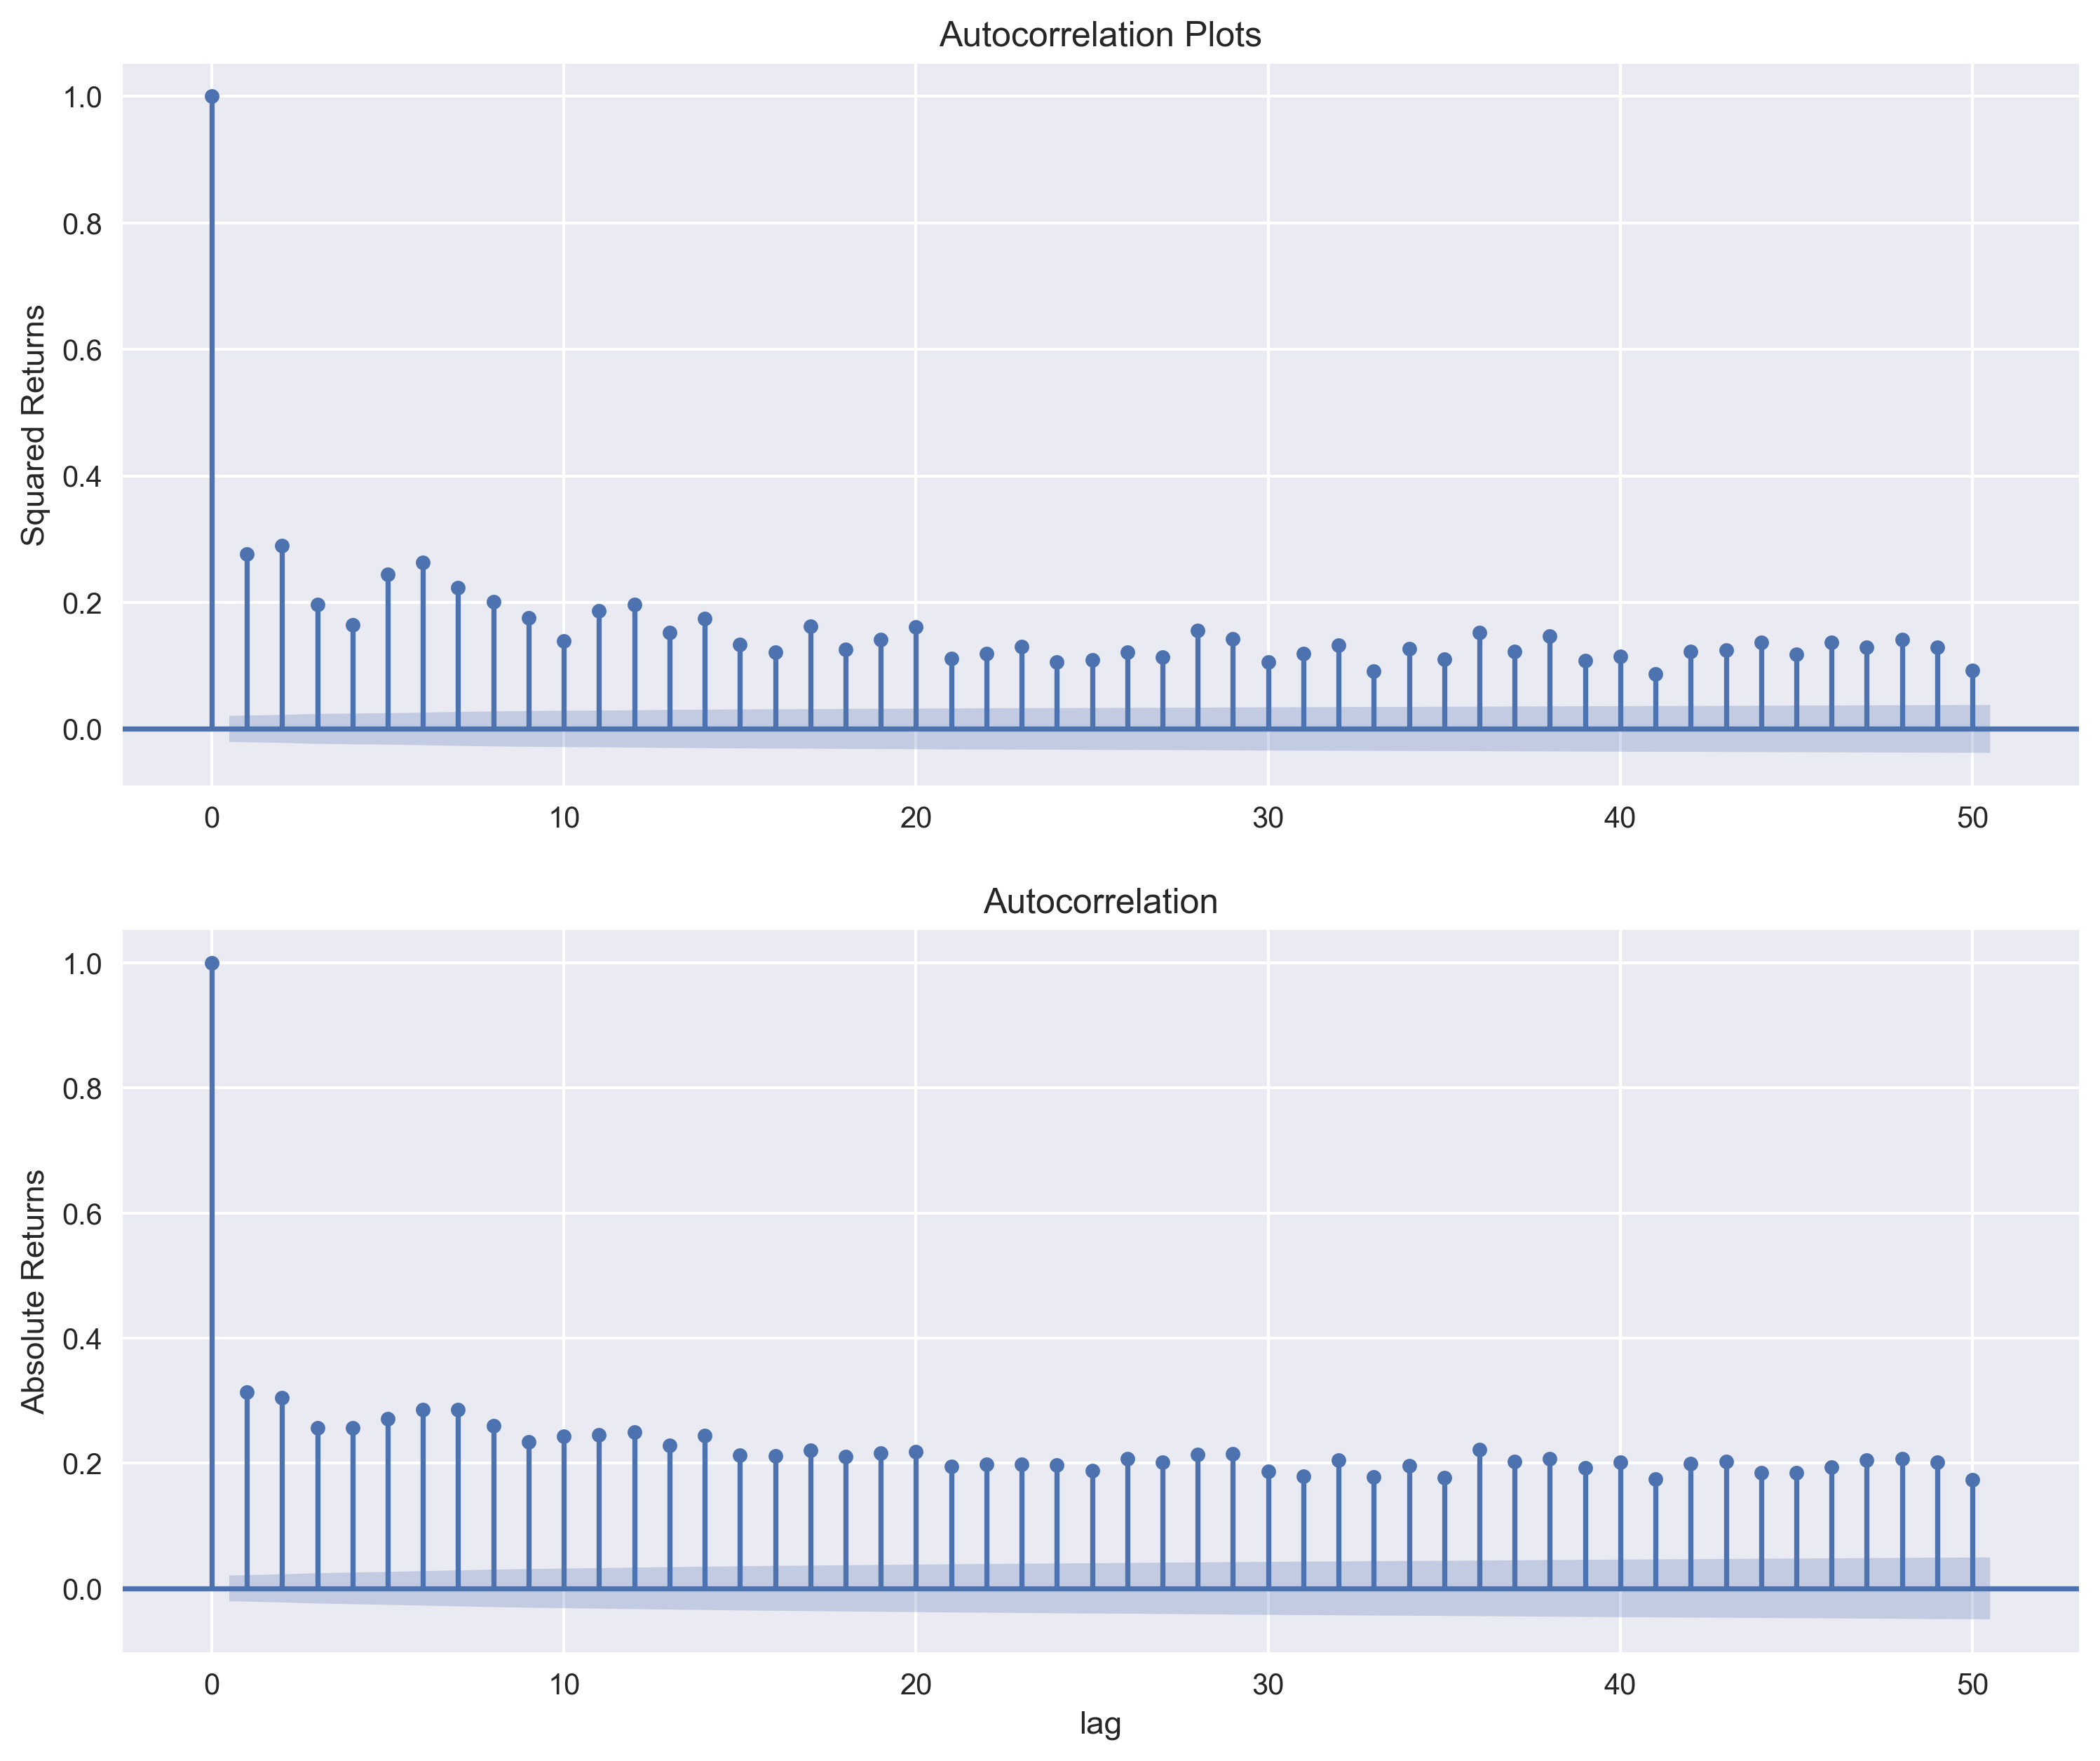

In [18]:
# Create the ACF plots 

fig, ax = plt.subplots (2, 1, figsize = (12, 10))

smt.graphics.plot_acf (df.log_rtn ** 2, lags = N_lags, alpha = significance_level, ax = ax[0])

ax[0].set (title = "Autocorrelation Plots", ylabel = "Squared Returns")

smt.graphics.plot_acf (np.abs (df.log_rtn), lags = N_lags, alpha = significance_level, ax = ax[1])

ax[1].set (ylabel = "Absolute Returns", xlabel = "lag")

plt.show()

Leverage Effect

In [19]:
# Calculate colatility measures as rolling standard deviations
df["moving_std_252"] = df [ ["log_rtn"]].rolling (window = 252).std ()
df["moving_std_21"] = df [ ["log_rtn"]].rolling (window = 21).std ()

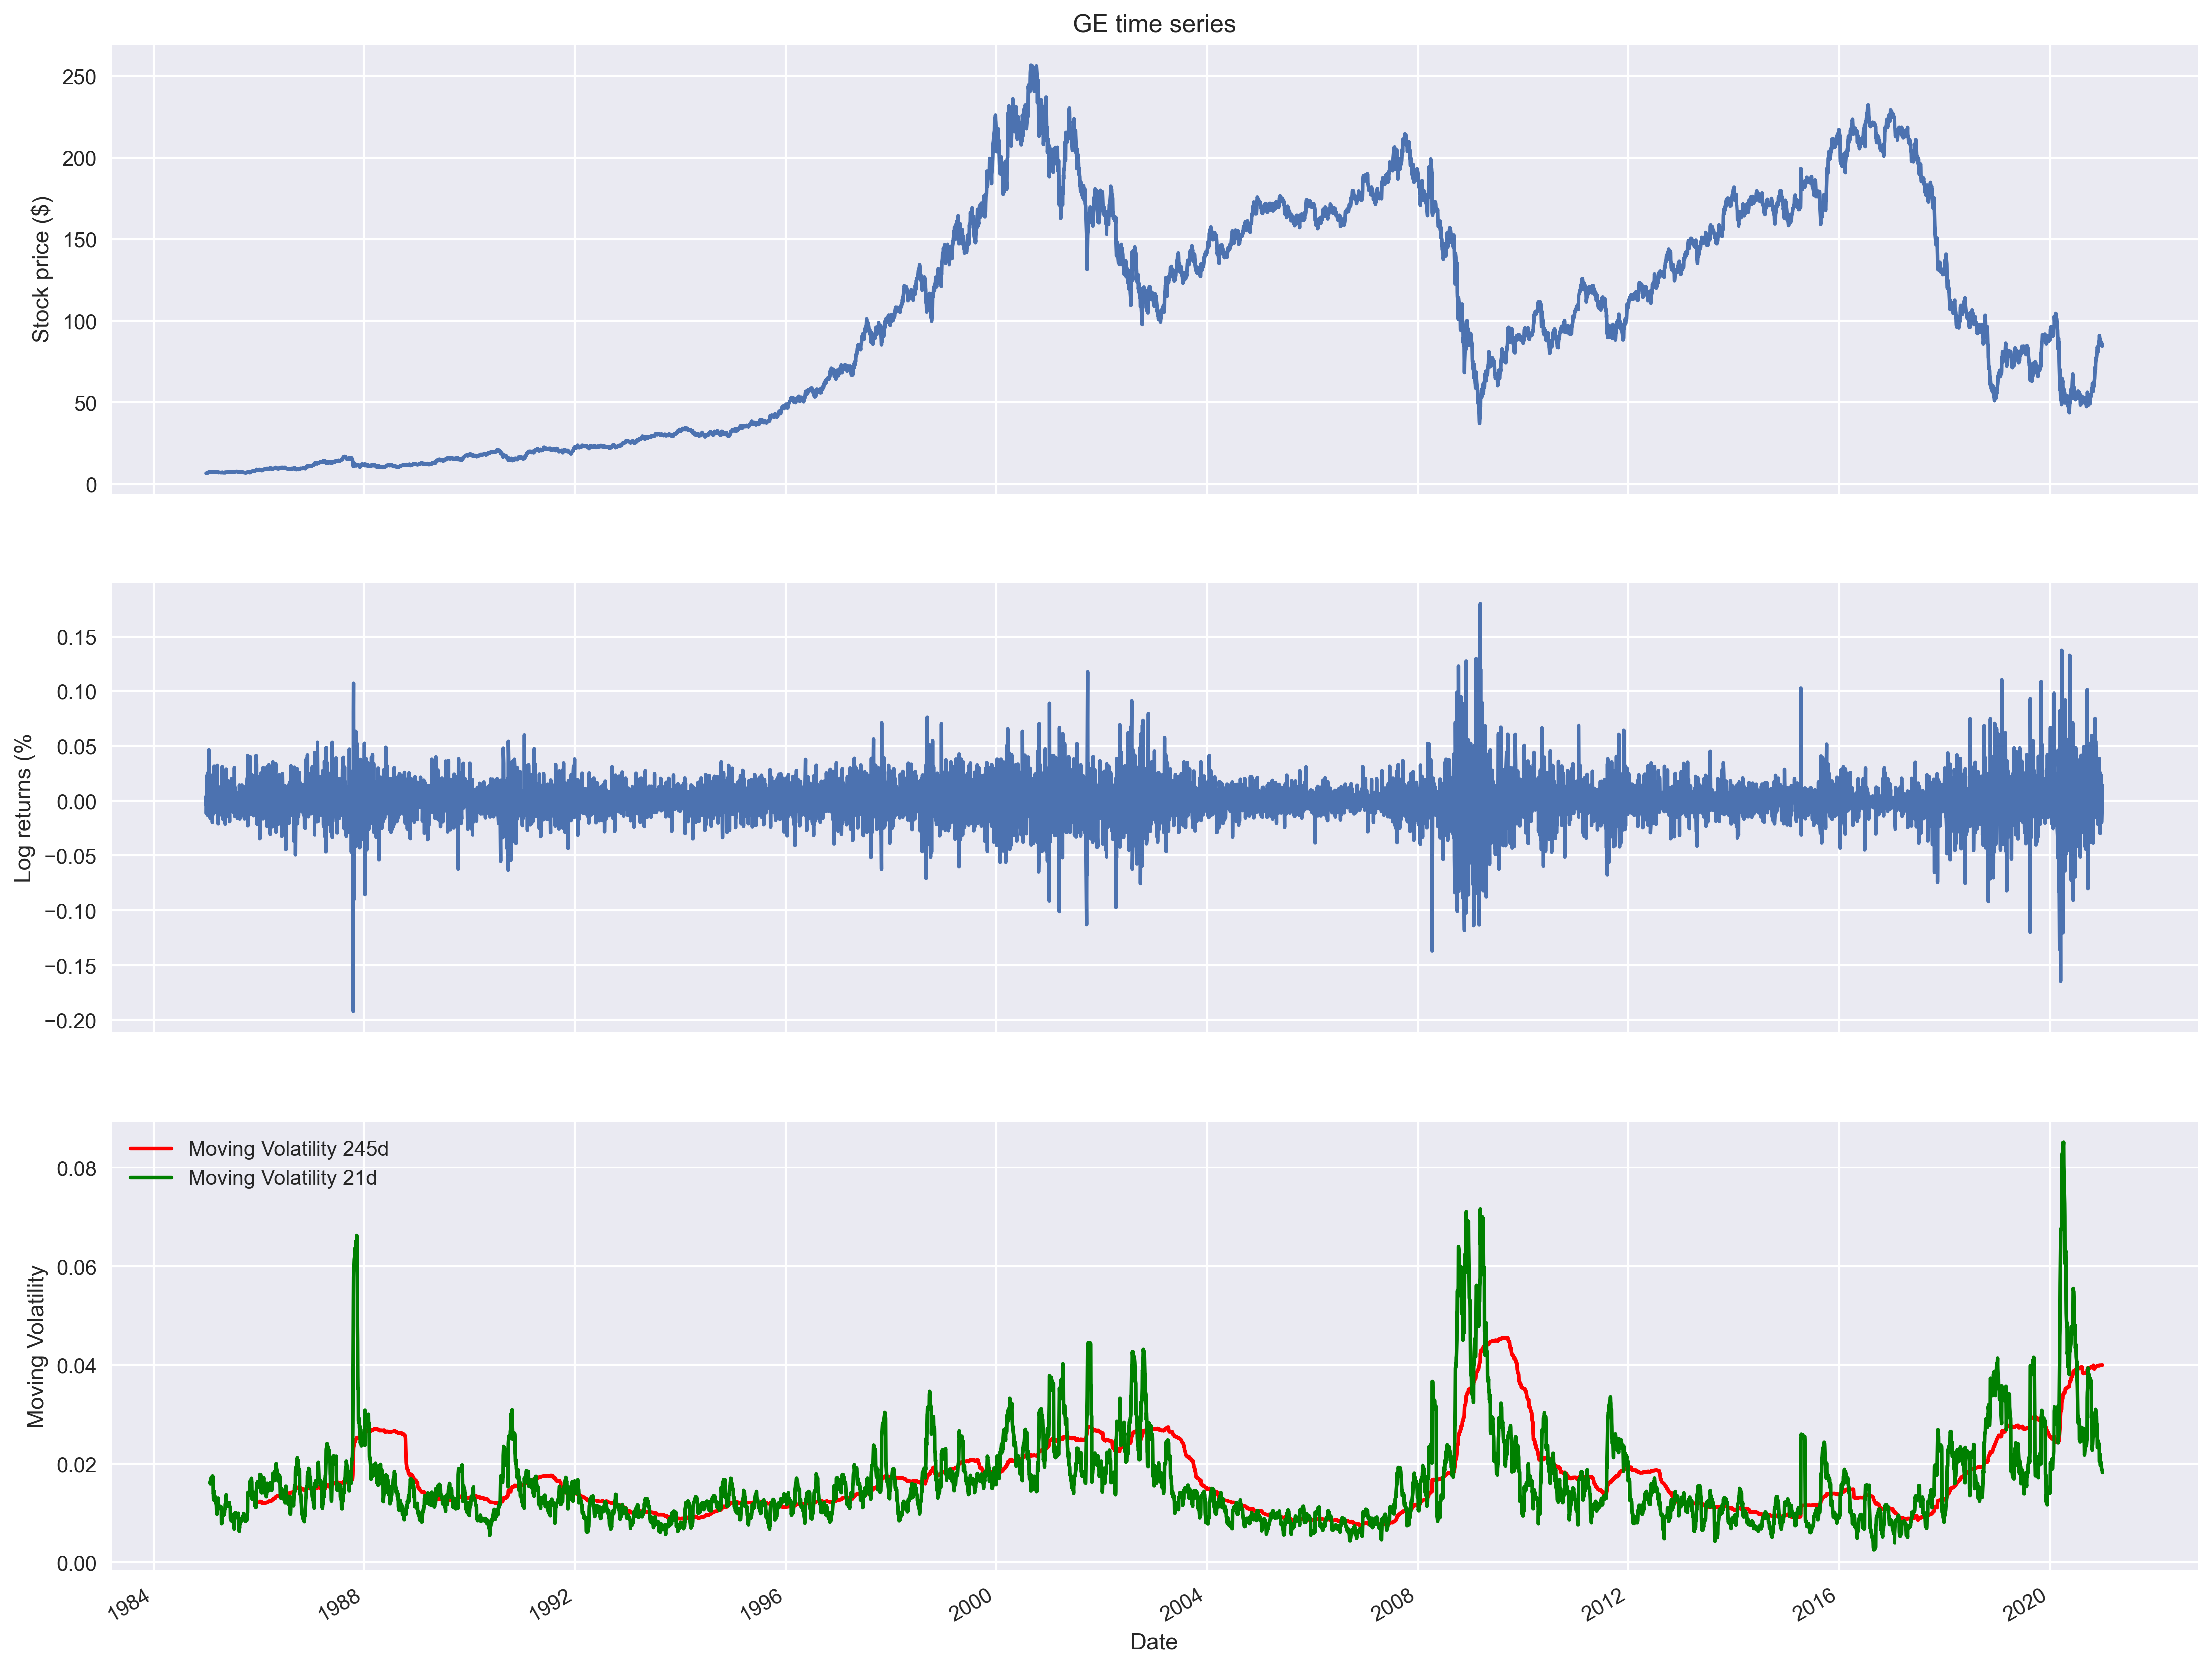

In [23]:
# Plot all the series for comparison 
fig, ax = plt.subplots (3, 1, figsize = (18, 15), sharex = True)

df.adj_close.plot (ax = ax[0])
ax[0].set (title = "GE time series", ylabel = "Stock price ($)")

df.log_rtn.plot (ax = ax [1])
ax[1].set (ylabel = "Log returns (%")

df.moving_std_252.plot (ax = ax [2], color = "r", label = "Moving Volatility 245d")
df.moving_std_21.plot (ax = ax [2], color = "g", label = "Moving Volatility 21d")
ax[2].set (ylabel = "Moving Volatility", xlabel = "Date")
ax[2].legend ()